In [ ]:
!pip install pandas
!pip install matplotlib
!pip install string
!pip install nltk
!pip install numpy
!pip install sklearn
!pip install xgboost
!pip install emoji
!pip installshap
!pip install gc
!pip install os
!pip install shap
!pip install re

# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC, SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import emoji 
import shap as shap

import gc
import os


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement string (from versions: none)
ERROR: No matching distribution found for string
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 197 kB 23.5 MB/s 
  Created

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nlt

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

from google.colab import drive

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
import nltk; nltk.download('popular')
from nltk.corpus import wordnet as wn


In [ ]:
drive.mount('/content/gdrive')
data_path = 'gdrive/MyDrive/THESIS/datasets'

df_balanced = pd.read_csv(data_path + '/prepped_data/df_balanced.csv')
comparison_file = pd.read_csv(data_path + '/comparison_file.csv')

In [ ]:
df_balanced.head()

In [ ]:
comparison_file.head()

In [ ]:
def preprocessor(data):
  pattern = r'(@\w+)|(#\w+)' # (http://[^"\s]+)|
  data['original_sentence'] = data['sentence']
  data['sentence'].str.replace(pattern, "")
  data['sentence'].str.replace('RT', "")
  data['sentence'].str.replace('AITA', "")

  data['sentence'].str.replace('bc', "because")

  # remove usernames
  data['sentence'] = [re.sub("([@#][A-Za-z0-9_]+)|(\w+:\/\/\S+)", "", s) for s in data['sentence']]

  # remove URLs
  data['sentence'] = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", "", s) for s in data['sentence']]

  # convert (non) emoji smiley faces & emoticons to words
  eyes = '[8:=;]'
  nose = "['`\-~]"

  data['sentence'] = [re.sub(f'{eyes}{nose}*[)]]+|[[(c]+{nose}*{eyes}', 'smile', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[pP]+', 'lolface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[(c\/]+|[)\/]+{nose}*{eyes}', 'sadface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[\|l]+', 'neutralface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(f'{eyes}{nose}*[oO$s@&]+', 'otherface', s) for s in data['sentence']]
  data['sentence'] = [re.sub(r'(<3)', 'heart', s) for s in data['sentence']]
  data['sentence'] = [re.sub(r'(</3)', 'brokenheart', s) for s in data['sentence']]

  data['sentence'] = [emoji.demojize(s) for s in data['sentence']]

  # remove digits
  # data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if not word.isdigit()]))
  data['sentence'] = [re.sub(r'[0-9\.]+', '', s) for s in data['sentence']]

  df_balanced['sentence'] = df_balanced['sentence'].str.replace('\d+', '')


  # lowercase
  data['sentence'] = [sentence.lower() for sentence in data['sentence']]

  data['sentence'].str.replace('aita', "")


  # remove punctuation
  data['sentence'] = [re.sub(r'[^\w\d\s\']+', '', s) for s in data['sentence']]

  # remove stopwords
  stops = set(stopwords.words('english'))
  data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))

  # remove first unnamed:0 column
  data = data.drop('Unnamed: 0', 1)

  return data

preprocessor(df_balanced)


In [ ]:
all_synonyms = []

for sentence in df_balanced['sentence']:
    synonyms = []
    for word in sentence.split():
        for syn in wordnet.synsets(word):
            for l in syn.lemmas():
                synonyms.append(l.name())
                
    all_synonyms.append(synonyms)

print(all_synonyms)
print(len(all_synonyms))


In [ ]:
df_balanced['synonyms'] = all_synonyms

In [ ]:
df_balanced.head()

In [ ]:
df_balanced.to_csv(data_path + '/df_balanced_WN.csv')

In [ ]:
# df_balanced.sample(1000).to_csv(data_path + '/df_balanced_WN_SAMPLE.csv')

In [ ]:

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier 
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

In [ ]:
# running this and next block of code in jupyter notebook (which hopefully goes faster, with the new chip)

def model(method, data = df_balanced, comp = comparison_file):
    X = data[['sentence', 'synonyms', 'original_sentence']]
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)
    
    count = CountVectorizer(max_features = 10000)
    c_vec = ColumnTransformer([
      ('c_vec_sentence', count, 'sentence'),
      ('c_vec_synonyms', count, 'synonyms')
      ])
    
    tfidf = TfidfVectorizer(max_features = 10000)
    t_vec = ColumnTransformer([
      ('t_vec_sentence', count, 'sentence'),
      ('t_vec_synonyms', count, 'synonyms')
      ])
    
    
    union = FeatureUnion([('c_vec', c_vec), ('t_vec', t_vec)])


    params = [{
    'union__c_vec__c_vec_sentence__analyzer': ['word'],
    'union__c_vec__c_vec_sentence__ngram_range': [(1, 1)],
    'union__c_vec__c_vec_synonyms__analyzer': ['word'],
    'union__c_vec__c_vec_synonyms__ngram_range': [(1, 1)],
    'union__t_vec__t_vec_sentence__analyzer': ['word'],
    'union__t_vec__t_vec_sentence__ngram_range': [(1, 1)],
    'union__t_vec__t_vec_synonyms__analyzer': ['word'],
    'union__t_vec__t_vec_synonyms__ngram_range': [(1, 1)],
    }]
    
    # left out : ('union', union), ('to_cuda', torch.from_numpy()),
    
    pipe = Pipeline(steps = [('union', union), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    
    gs = GridSearchCV(pipe, params, cv = 5, scoring = 'accuracy', n_jobs = -1, refit = True, verbose = 5, error_score='raise')
    gs.fit(X_train[['sentence', 'synonyms']], y_train)
    %time gs.fit(X_train[['sentence', 'synonyms']], y_train)
    
    estimator = gs.best_estimator_
    y_pred = estimator.predict(X_test[['sentence', 'synonyms']])

    print("Best Parameters: \n{}\n".format(gs.best_params_))
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    comp_pred = estimator.predict(comp)

    return estimator, y_pred, y_test, X_test['sentence'], X_test['original_sentence'], comp, comp_pred

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold, lemmas, sentence, comparison, comparison_pred = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    
    out_file = 'gdrive/MyDrive/THESIS/results/'  + 'Results_' + 'SVC_WN' +'_pred_COPY_5000' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold), list(lemmas), list(sentence))), columns = ['id', 'label', 'gold', 'input', 'sentence'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)

    out_file_comp = 'results/'  + 'Results_' + 'SVC_WN' +'_comp' + ext
    output_comp = pd.DataFrame(list(zip(list(comparison), list(comparison_pred))), columns = ['sentence', 'label'])
    output_comp['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output_comp.to_csv(out_file_comp, sep=',', encoding='utf-8', index = False)

    return output.head(), estimator


In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, data_path+'/df_balanced_WN.csv', data_path + '/comparison_file.csv' )

In [ ]:
# model with OOVs replaced by a synonym

In [ ]:
df_oov = pd.read_csv('datasets/prepped_data/df_balanced.csv')
df_oov

,Unnamed: 0.1,Unnamed: 0,sentence,label
0,0,136,aita someone interrupts speaking continue spea...,0
1,1,464,greeted slap face,0
2,2,555,aita demanding tinder date pay half bill amoun...,0
3,3,731,son anxious swimming ocean rent movie jaws,0
4,4,865,fed tigers prepared human meat butcher,0
...,...,...,...,...
97775,97775,96283,roughly young men incel mean they're virgins p...,1
97776,97776,28699,decided build post based worked,1
97777,97777,91525,im sure thread died interest manitoba hope rea...,1
97778,97778,87000,anyone realize said post daddy shooting hand d...,1


In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 10000) 
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(word):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 19min 3s, sys: 10 µs, total: 19min 3s
Wall time: 19min 3s
Accuracy: 82.43335378741392%
              precision    recall  f1-score   support

           0       0.77      0.93      0.84     14667
           1       0.92      0.71      0.80     14667

    accuracy                           0.82     29334
   macro avg       0.84      0.82      0.82     29334
weighted avg       0.84      0.82      0.82     29334

Confusion Matrix : 
[[13710   957]
 [ 4196 10471]]


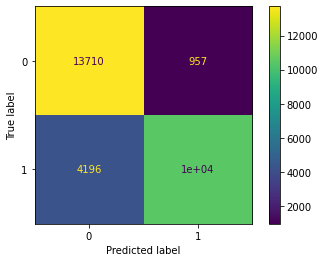

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 50000) 
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(w):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred_50000' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 20min 31s, sys: 136 ms, total: 20min 31s
Wall time: 20min 32s
Accuracy: 82.70607486193495%
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     14667
           1       0.92      0.71      0.81     14667

    accuracy                           0.83     29334
   macro avg       0.84      0.83      0.82     29334
weighted avg       0.84      0.83      0.82     29334

Confusion Matrix : 
[[13777   890]
 [ 4183 10484]]


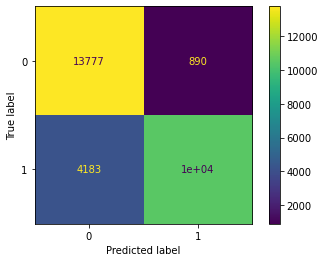

NameError: name 'estimator' is not defined

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 200000)
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(w):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 20min 59s, sys: 16 ms, total: 20min 59s
Wall time: 20min 59s
Accuracy: 82.70607486193495%
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     14667
           1       0.92      0.71      0.81     14667

    accuracy                           0.83     29334
   macro avg       0.84      0.83      0.82     29334
weighted avg       0.84      0.83      0.82     29334

Confusion Matrix : 
[[13777   890]
 [ 4183 10484]]


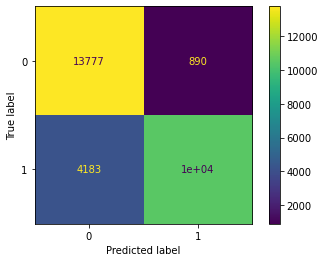

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 400000)
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(w):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 21min 17s, sys: 20 ms, total: 21min 17s
Wall time: 21min 18s
Accuracy: 82.70607486193495%
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     14667
           1       0.92      0.71      0.81     14667

    accuracy                           0.83     29334
   macro avg       0.84      0.83      0.82     29334
weighted avg       0.84      0.83      0.82     29334

Confusion Matrix : 
[[13777   890]
 [ 4183 10484]]


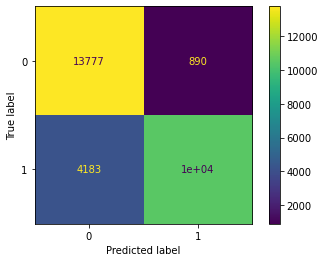

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 100000000) 
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(w):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 21min 13s, sys: 20 ms, total: 21min 13s
Wall time: 21min 13s
Accuracy: 82.70607486193495%
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     14667
           1       0.92      0.71      0.81     14667

    accuracy                           0.83     29334
   macro avg       0.84      0.83      0.82     29334
weighted avg       0.84      0.83      0.82     29334

Confusion Matrix : 
[[13777   890]
 [ 4183 10484]]


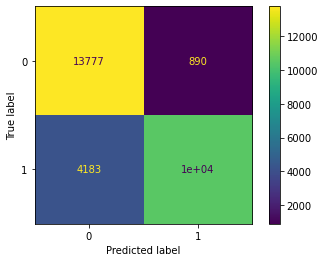

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 300000000) 
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(w):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 20min 58s, sys: 180 ms, total: 20min 58s
Wall time: 20min 59s
Accuracy: 82.70607486193495%
              precision    recall  f1-score   support

           0       0.77      0.94      0.84     14667
           1       0.92      0.71      0.81     14667

    accuracy                           0.83     29334
   macro avg       0.84      0.83      0.82     29334
weighted avg       0.84      0.83      0.82     29334

Confusion Matrix : 
[[13777   890]
 [ 4183 10484]]


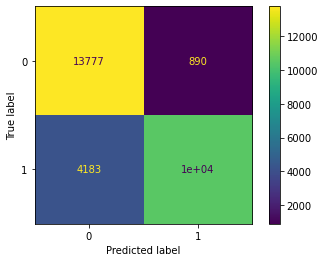

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 5000) 
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(w):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 15min 10s, sys: 4.01 ms, total: 15min 10s
Wall time: 15min 11s
Accuracy: 82.1913138337765%
              precision    recall  f1-score   support

           0       0.77      0.93      0.84     14667
           1       0.91      0.72      0.80     14667

    accuracy                           0.82     29334
   macro avg       0.84      0.82      0.82     29334
weighted avg       0.84      0.82      0.82     29334

Confusion Matrix : 
[[13590  1077]
 [ 4147 10520]]


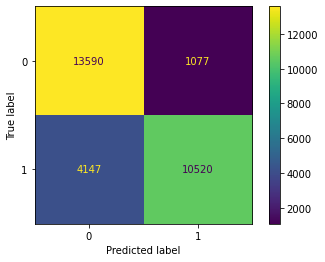

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 1000) 
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(w):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 7min 54s, sys: 88 ms, total: 7min 54s
Wall time: 7min 54s
Accuracy: 79.42319492738802%
              precision    recall  f1-score   support

           0       0.77      0.85      0.80     14667
           1       0.83      0.74      0.78     14667

    accuracy                           0.79     29334
   macro avg       0.80      0.79      0.79     29334
weighted avg       0.80      0.79      0.79     29334

Confusion Matrix : 
[[12434  2233]
 [ 3803 10864]]


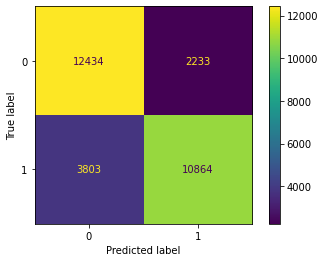

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
def model(method, data = df_oov):
    X = data['sentence']
    y = data['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, stratify = y, random_state=101)

    vectorizer = CountVectorizer(max_features = 500)
    document_term_matrix = vectorizer.fit_transform([s for s in X_train])
    train_vocab = vectorizer.vocabulary_

    # replace oov words in test set with a synonym (found via wordnet) that is present in the training vocab
    for s in X_test:
        for w in s.split():
            if w not in train_vocab:
                synonyms = []
                for syn in wordnet.synsets(w):
                    for l in syn.lemmas():
                        synonyms.append(l.name())
                for syn in synonyms:
                    if syn in train_vocab:
                        s.replace(w, syn)
                        break


    
    pipe = Pipeline(steps = [('vectorizer', vectorizer), ('svc', SVC(gamma = 1, kernel = 'rbf'))])
    pipe.fit(X_train, y_train)
    %time pipe.fit(X_train, y_train)
    
    y_pred = pipe.predict(X_test)
    
    metrics.f1_score(y_test, y_pred, average='weighted')
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()
    
    return estimator, y_pred, y_test

def generate_output_file(method, filename: str):
    test = pd.read_csv(filename)
    test.sentence = test.sentence.astype(str)
    id = test.index.to_list()
    estimator, label, gold = model(method, test)
    gc.collect()
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = 'results/'  + 'Results_' + 'SVC_OOV' +'_pred' + ext
    output = pd.DataFrame(list(zip(id, list(label), list(gold))), columns = ['id', 'label', 'gold'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output['gold'] = np.where(output['gold'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return output.head(), estimator

CPU times: user 8min 51s, sys: 52 ms, total: 8min 51s
Wall time: 8min 51s
Accuracy: 77.18006408945251%
              precision    recall  f1-score   support

           0       0.76      0.79      0.78     14667
           1       0.78      0.75      0.77     14667

    accuracy                           0.77     29334
   macro avg       0.77      0.77      0.77     29334
weighted avg       0.77      0.77      0.77     29334

Confusion Matrix : 
[[11608  3059]
 [ 3635 11032]]


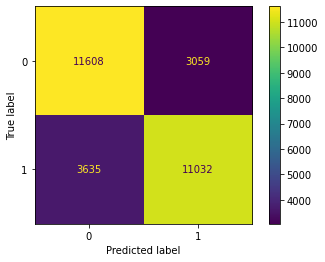

In [ ]:
method = SVC(gamma = 1, kernel = 'rbf')
output, estimator = generate_output_file(method, 'datasets/prepped_data/df_balanced.csv')

In [ ]:
# experimented with ensemble model (found optimal hyperparameters for each classifier in other notebook), but not used eventually.
import pandas as pd
from nltk import word_tokenize, TweetTokenizer, pos_tag

! pip3 install varname
from varname import nameof

import pandas as pd
# import tensorflow as tf
import re
import numpy as np
import seaborn as sn
import csv
import os

from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier 
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def model_ensemble(data = df_balanced):
    preprocessor(data)
    X = data[['sentence']]
    y = data['label']
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y, random_state= 42)

    # classifiers with optimal hyperparameters, found in other notebook (excluded, because didnt use this model eventually)
    clf1 = LogisticRegression(C = 100, solver = 'liblinear', penalty = 'l2') 
    clf2 = BernoulliNB(alpha = 0.1)
    clf3 = MultinomialNB(alpha = 0.1) 
    clf4 = SVC(gamma = 1, kernel = 'rbf')
    clf5 = XGBClassifier(booster = 'gbtree')
    
    count = CountVectorizer(max_features = 10000)
    c_vec = ColumnTransformer([
      ('c_vec_sentence', count, 'sentence')])
    
    tfidf = TfidfVectorizer(max_features = 10000)
    t_vec = ColumnTransformer([
      ('t_vec_sentence', count, 'sentence')])
    
    union = FeatureUnion([('c_vec', c_vec), ('t_vec', t_vec)])

    # 78, 74, 75, 82, 64

    vclf = VotingClassifier(estimators = [('lr1', clf1), ('bnb', clf2), ('mnb', clf3), ('svc', clf4), ('gbt', clf5)],
                                          voting = 'soft', weights = [5, 3, 4, 8, 1],
                                          flatten_transform = True)
    
    params = [{
    'union__c_vec__c_vec_sentence__analyzer': ['word'],
    'union__c_vec__c_vec_sentence__ngram_range': [(1, 1)],
    'union__t_vec__t_vec_sentence__analyzer': ['word'],
    'union__t_vec__t_vec_sentence__ngram_range': [(1, 1)],
    'vclf__bnb__alpha': [0.5],
    'vclf__bnb__fit_prior': [True],
    'vclf__mnb__alpha': [0.01],
    'vclf__mnb__fit_prior': [False]
    }]

    
    
    ensemble_pipe = Pipeline(steps = [('union', union), ('vclf', vclf)])  
    
    gs = GridSearchCV(ensemble_pipe, params, cv = 5, scoring = 'accuracy', n_jobs = -1, refit = True, verbose = 5)
    gs.fit(X_train, y_train)
    %time gs.fit(X_train, y_train)
    
    estimator = gs.best_estimator_
    y_pred = estimator.predict(X_test)
    
    print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
    
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix : \n' + str(cm))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plot = plt.show()


    for clf in (clf1, clf2, clf3, clf4, clf5):
      print('Results for the seperate classifiers')
      clf.fit(X_train, y_train)
      y_pred = clf.predict(X_test)
      print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
    
      return estimator, y_pred, cm, plot

def make_predictions(test_set, data = df_balanced):
    estimator = model_ensemble(data)[0]

    test = preprocessor(test_set)
    pred = estimator.predict(test_set)
    return pred

def generate_output_file(filename: str):
    test = pd.read_csv(filename)
    id = test.index.to_list()
    label = list(make_predictions(test))
    name, ext = os.path.splitext(os.path.basename(filename))
    out_file = '/content/gdrive/MyDrive/THESIS/results/'  + name + '_ENSEMBLE_all_pred' + ext
    output = pd.DataFrame(list(zip(id, label)), columns = ['id', 'label'])
    output['label'] = np.where(output['label'] == 0, 'not okay', 'okay')
    output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
    return 

generate_output_file('gdrive/MyDrive/THESIS/datasets/prepped_data/df_balanced.csv')


The default value of regex will change from True to False in a future version.
In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


Fitting 5 folds for each of 1 candidates, totalling 5 fits


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
One or more of the test scores are non-finite: [nan]


Fitting 5 folds for each of 1 candidates, totalling 5 fits
